## Regional Wage Deflators Revisited

In [1]:
# Import preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)
import itertools, os
from pathlib import Path

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# bd CPS files
cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]


# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

# Binned Wage Calculation
def binned_wage(df, wage_var='WKEARN', percentile=0.1, wgt_var='PWORWGT',
                bins=np.arange(-25, 3000, 50)):
    '''
    Returns wage estimate based on linear interpolation through 
    the bin containing the wage.
    
    perc = percentile of interest (0.5 is median)
    bins = list of bin start locations
    '''
    cdf = (df.groupby(pd.cut(df[wage_var], bins))
             [wgt_var].sum().cumsum() / df[wgt_var].sum())
    
    return np.interp(percentile, cdf, bins[1:])

In [31]:
# Get CPS data
cols = ['YEAR', 'MONTH', 'FEMALE', 'AGE', 'NILFREASON', 
        'LFS', 'BASICWGT', 'CPSID', 'LINENO', 'WBHAO',
        'PWORWGT', 'WKEARN', 'HRSUSL1', 'WORKFT', 
        'PRICEADJ', 'HRWAGE', 'REGION']

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                for year in range(1994, 2024)])
df['RWKEARN'] = df['WKEARN'] * df['PRICEADJ']
dfc = df.query('RWKEARN > 0 ')

In [65]:
dfc = df.query('RWKEARN > 0')

In [14]:
# Get CPI from FRED 
cpi = fred_df('CPIAUCNS')
defl = (cpi.iloc[-1] / cpi)

In [66]:
data = pd.DataFrame()
# Calculate wage for percentile p
for p in [10, 25, 50, 75, 90]:
    data[f'p{p}'] = (dfc.groupby(['YEAR', 'MONTH'])
                     .apply(lambda x: binned_wage(x, wage_var='RWKEARN', percentile=p/100)))
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') 
              for ti in data.index]

data2 = pd.DataFrame()
# Calculate wage for percentile p
for p in [10, 25, 50, 75, 90]:
    data2[f'p{p}'] = (dfc.groupby(['YEAR', 'MONTH'])
                     .apply(lambda x: binned_wage(x, wage_var='WKEARN', 
                                                  percentile=p/100)))
data2.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') 
              for ti in data2.index]

<AxesSubplot: >

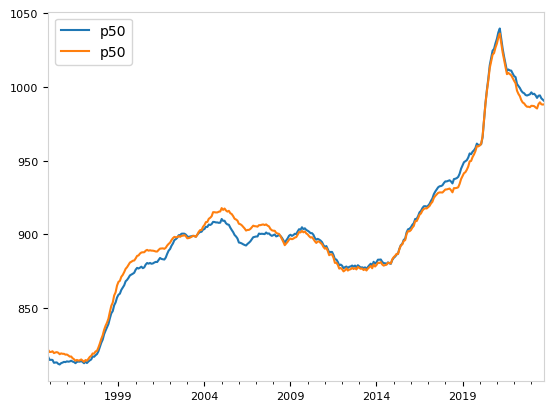

In [67]:
data2a = data2.multiply(defl['CPIAUCNS'], axis=0).dropna()
pd.concat([data, data2a], axis=1)['p50'].rolling(12).mean().dropna().plot()

<AxesSubplot: >

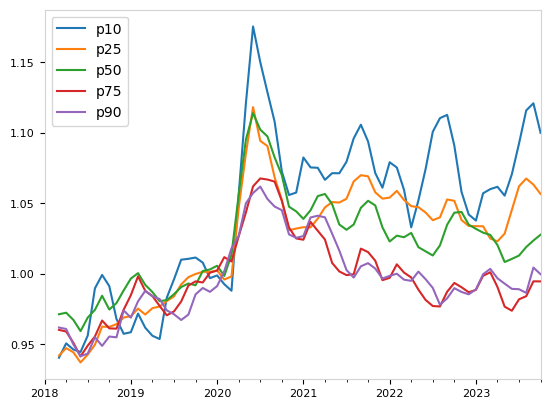

In [73]:
(data / data.loc['2020-01-01']).loc['2018':].rolling(3).mean().plot()

In [60]:
tmp = data.diff(12).dropna()

,p10,p25,p50,p75,p90
1994-01-01,218.491126,472.095462,785.626611,1242.534276,1766.461569
1994-02-01,203.183545,444.970759,771.542975,1257.703303,1812.699288
1994-03-01,200.829239,440.971544,780.063522,1252.519329,1806.007293
1994-04-01,229.707530,469.353216,783.242179,1268.557085,1756.108980
1994-05-01,225.887918,440.941157,777.521276,1207.229072,1717.367159
...,...,...,...,...,...
2023-06-01,320.525449,630.213802,994.834712,1549.877369,2242.639609
2023-07-01,326.811417,647.427738,991.225320,1562.035513,2397.314301
2023-08-01,352.972227,640.864700,984.458674,1570.455605,2475.938907
2023-09-01,357.667412,628.096806,957.442907,1483.225634,2322.501758


In [ ]:
data2 = pd.DataFrame()
# Calculate wage for percentile p
for p in [10, 25, 50, 75, 90]:
    data2[f'p{p}'] = (dfc.groupby(['YEAR', 'MONTH'])
                     .apply(lambda x: binned_wage(x, wage_var='WKEARN', 
                                                  percentile=p/100)))
data2.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') 
              for ti in data2.index]

In [15]:
data = pd.DataFrame()
# Calculate wage for percentile p
for p in [10, 25, 50, 75, 90]:
    data[f'p{p}'] = (dfc.groupby(['YEAR', 'MONTH'])
                     .apply(lambda x: binned_wage(x, wage_var='RWKEARN', percentile=p/100)))
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') 
              for ti in data.index]

In [25]:
data2a = data2.multiply(defl['CPIAUCNS'], axis=0).dropna()
pd.concat([data, data2a], axis=1).plot()

<AxesSubplot: >

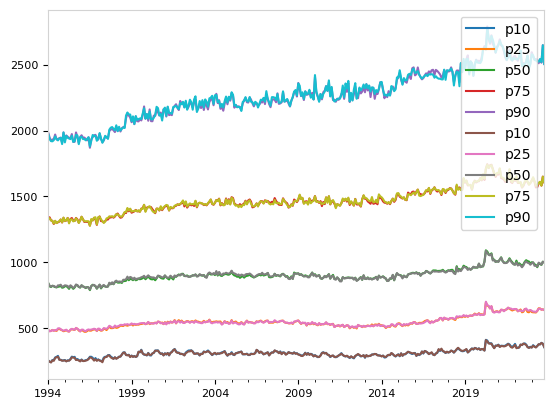

In [30]:
pd.concat([data, data2a], axis=1).plot()

In [29]:
pd.concat([data, data2a])

,p10,p25,p50,p75,p90
1994-01-01,255.335890,485.677746,843.173540,1341.570603,1984.852390
1994-02-01,246.124508,477.358673,817.848138,1341.270998,1947.013397
1994-03-01,242.058424,480.039640,812.715771,1318.117709,1922.714203
1994-04-01,257.997700,486.318412,821.937454,1315.042425,1932.078191
1994-05-01,258.057779,481.675927,817.058553,1291.263816,1935.372873
...,...,...,...,...,...
2023-06-01,378.483980,647.621795,997.679316,1603.170503,2522.982314
2023-07-01,376.511683,648.310094,991.008130,1611.408476,2541.268136
2023-08-01,388.380108,641.015512,982.095316,1582.388124,2519.675197
2023-09-01,381.747295,642.947494,1004.510280,1650.269815,2647.554131


,YEAR,MONTH,FEMALE,AGE,NILFREASON,LFS,BASICWGT,CPSID,LINENO,WBHAO,PWORWGT,WKEARN,HRSUSL1,WORKFT,PRICEADJ,HRWAGE
18,1994,2,0,50,nan,Employed,2222.523926,931104728.0,1,White,8953.781250,1130.430054,40,0,2.095129,28.260750
19,1994,2,1,47,nan,Employed,1967.897949,931104728.0,2,White,7648.005371,810.809998,40,1,2.095129,20.270250
49,1994,2,0,42,nan,Employed,2700.394287,931116542.0,1,Black,10227.323242,170.000000,40,1,2.095129,5.000000
50,1994,2,1,40,nan,Employed,2172.468994,931116542.0,2,Black,8198.772461,190.000000,39,1,2.095129,6.950000
55,1994,2,0,51,nan,Employed,2222.523926,931117597.0,1,White,8953.781250,600.000000,40,1,2.095129,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993200,2023,6,1,63,nan,Employed,385.880798,220330550.0,2,White,1566.954712,1064.800049,40,1,1.010048,26.620001
993201,2023,6,0,49,nan,Employed,435.025696,230345760.0,1,White,1693.212036,831.200012,40,0,1.010048,20.780001
993216,2023,6,0,38,nan,Employed,484.485596,220331065.0,1,White,1899.608032,720.000000,40,1,1.010048,18.000000
993217,2023,6,1,39,nan,Employed,370.082214,220331065.0,2,White,1455.053345,360.000000,18,0,1.010048,20.000000


In [8]:
4753610 > 4877066

False

In [ ]:
def binned_wage(df, wage_var='WKEARN', percentile=0.1, wgt_var='PWORWGT',
                bins=np.arange(-25, 3000, 50)):
    '''
    Returns wage estimate based on linear interpolation through 
    the bin containing the wage.
    
    perc = percentile of interest (0.5 is median)
    bins = list of bin start locations
    '''
    cdf = (df.groupby(pd.cut(df[wage_var], bins))
             [wgt_var].sum().cumsum() / df[wgt_var].sum())
    
    return np.interp(percentile, cdf, bins[1:])